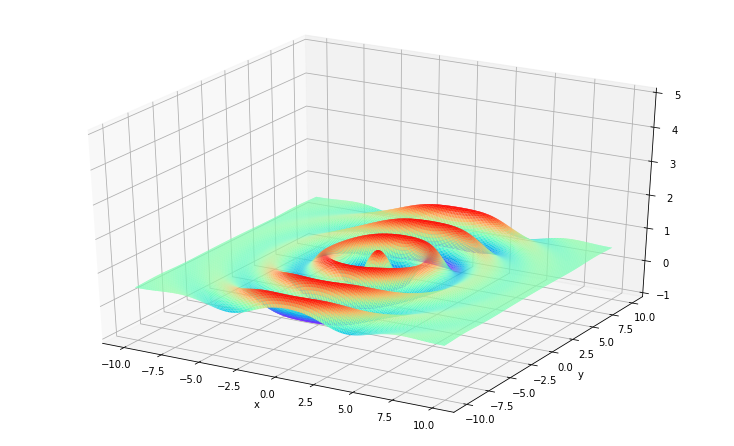

In [7]:
# 画出图像如下
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10,6))
ax = Axes3D(fig)
x = np.arange(-10, 10, 0.1)
y = np.arange(-10, 10, 0.1)
X, Y = np.meshgrid(x, y)       
Z = 0.5 - (np.sin(np.sqrt(X**2+Y**2))**2 - 0.5)/(1 + 0.001*(x**2 + y**2)**2)
plt.xlabel('x')
plt.ylabel('y')
ax.set_zlim([-1,5])
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

In [8]:
import math, random

class Population:
    # 种群的设计
    def __init__(self, size, chrom_size, cp, mp, gen_max):
        # 种群信息合
        self.individuals = []          # 个体集合
        self.fitness = []              # 个体适应度集
        self.selector_probability = [] # 个体选择概率集合
        self.new_individuals = []      # 新一代个体集合

        self.elitist = {'chromosome':[0, 0], 'fitness':0, 'age':0} # 最佳个体的信息

        self.size = size # 种群所包含的个体数
        self.chromosome_size = chrom_size # 个体的染色体长度
        self.crossover_probability = cp   # 个体之间的交叉概率
        self.mutation_probability = mp    # 个体之间的变异概率
         
        self.generation_max = gen_max # 种群进化的最大世代数
        self.age = 0                  # 种群当前所处世代
          
        # 随机产生初始个体集，并将新一代个体、适应度、选择概率等集合以 0 值进行初始化
        v = 2 ** self.chromosome_size - 1
        for i in range(self.size):
            self.individuals.append([random.randint(0, v), random.randint(0, v)])
            self.new_individuals.append([0, 0])
            self.fitness.append(0)
            self.selector_probability.append(0)

    # 基于轮盘赌博机的选择
    def decode(self, interval, chromosome):
        '''将一个染色体 chromosome 映射为区间 interval 之内的数值'''
        d = interval[1] - interval[0]
        n = float (2 ** self.chromosome_size -1)
        return (interval[0] + chromosome * d / n)
     
    def fitness_func(self, chrom1, chrom2):
        '''适应度函数，可以根据个体的两个染色体计算出该个体的适应度'''
        interval = [-10.0, 10.0]
        (x, y) = (self.decode(interval, chrom1), 
                  self.decode(interval, chrom2))
        n = lambda x, y: math.sin(math.sqrt(x*x + y*y)) ** 2 - 0.5
        d = lambda x, y: (1 + 0.001 * (x*x + y*y)) ** 2
        func = lambda x, y: 0.5 - n(x, y)/d(x, y)
        return func(x, y)
         
    def evaluate(self):
        '''用于评估种群中的个体集合 self.individuals 中各个个体的适应度'''
        sp = self.selector_probability
        for i in range (self.size):
            self.fitness[i] = self.fitness_func (self.individuals[i][0],   # 将计算结果保存在 self.fitness 列表中
                                                 self.individuals[i][1])
        ft_sum = sum (self.fitness)
        for i in range (self.size):
            sp[i] = self.fitness[i] / float (ft_sum)   # 得到各个个体的生存概率
        for i in range (1, self.size):
            sp[i] = sp[i] + sp[i-1]   # 需要将个体的生存概率进行叠加，从而计算出各个个体的选择概率

    # 轮盘赌博机（选择）
    def select(self):
        (t, i) = (random.random(), 0)
        for p in self.selector_probability:
            if p > t:
                break
            i = i + 1
        return i

    # 交叉
    def cross(self, chrom1, chrom2):
        p = random.random()    # 随机概率
        n = 2 ** self.chromosome_size -1
        if chrom1 != chrom2 and p < self.crossover_probability:
            t = random.randint(1, self.chromosome_size - 1)   # 随机选择一点（单点交叉）
            mask = n << t    # << 左移运算符
            (r1, r2) = (chrom1 & mask, chrom2 & mask)   # & 按位与运算符：参与运算的两个值,如果两个相应位都为1,则该位的结果为1,否则为0
            mask = n >> (self.chromosome_size - t)
            (l1, l2) = (chrom1 & mask, chrom2 & mask)
            (chrom1, chrom2) = (r1 + l2, r2 + l1)
        return (chrom1, chrom2)

    # 变异
    def mutate(self, chrom):
        p = random.random ()
        if p < self.mutation_probability:
            t = random.randint (1, self.chromosome_size)
            mask1 = 1 << (t - 1)
            mask2 = chrom & mask1
            if mask2 > 0:
                chrom = chrom & (~mask2)  # ~ 按位取反运算符：对数据的每个二进制位取反,即把1变为0,把0变为1 
            else:
                chrom = chrom ^ mask1   # ^ 按位异或运算符：当两对应的二进位相异时，结果为1 
        return chrom

    # 保留最佳个体
    def reproduct_elitist (self):
        # 与当前种群进行适应度比较，更新最佳个体
        j = -1
        for i in range (self.size):
            if self.elitist['fitness'] < self.fitness[i]:
                j = i
                self.elitist['fitness'] = self.fitness[i]
        if (j >= 0):
            self.elitist['chromosome'][0] = self.individuals[j][0]
            self.elitist['chromosome'][1] = self.individuals[j][1]
            self.elitist['age'] = self.age

    # 进化过程
    def evolve(self):
        indvs = self.individuals
        new_indvs = self.new_individuals
        # 计算适应度及选择概率
        self.evaluate()
        # 进化操作
        i = 0
        while True:
            # 选择两个个体，进行交叉与变异，产生新的种群
            idv1 = self.select()
            idv2 = self.select()
            # 交叉
            (idv1_x, idv1_y) = (indvs[idv1][0], indvs[idv1][1])
            (idv2_x, idv2_y) = (indvs[idv2][0], indvs[idv2][1])
            (idv1_x, idv2_x) = self.cross(idv1_x, idv2_x)
            (idv1_y, idv2_y) = self.cross(idv1_y, idv2_y)
            # 变异
            (idv1_x, idv1_y) = (self.mutate(idv1_x), self.mutate(idv1_y))
            (idv2_x, idv2_y) = (self.mutate(idv2_x), self.mutate(idv2_y))
            (new_indvs[i][0], new_indvs[i][1]) = (idv1_x, idv1_y)  # 将计算结果保存于新的个体集合self.new_individuals中
            (new_indvs[i+1][0], new_indvs[i+1][1]) = (idv2_x, idv2_y)
            # 判断进化过程是否结束
            i = i + 2         # 循环self.size/2次，每次从self.individuals 中选出2个
            if i >= self.size:
                break
        
        # 最佳个体保留
        # 如果在选择之前保留当前最佳个体，最终能收敛到全局最优解。
        self.reproduct_elitist()

        # 更新换代：用种群进化生成的新个体集合 self.new_individuals 替换当前个体集合
        for i in range (self.size):
            self.individuals[i][0] = self.new_individuals[i][0]
            self.individuals[i][1] = self.new_individuals[i][1]

    def run(self):
        '''根据种群最大进化世代数设定了一个循环。
        在循环过程中，调用 evolve 函数进行种群进化计算，并输出种群的每一代的个体适应度最大值、平均值和最小值。'''
        for i in range (self.generation_max):
            self.evolve ()
            print (i, max (self.fitness), sum (self.fitness)/self.size, min (self.fitness))
if __name__ == '__main__':
    # 种群的个体数量为 50，染色体长度为 25，交叉概率为 0.8，变异概率为 0.1, 进化最大世代数为 150
    pop = Population (50, 24, 0.8, 0.1, 150)
    pop.run()

0 0.9901445201995174 0.5773891560328831 0.021718244380254048
1 0.9902187783703713 0.7102355782374087 0.059257433626424494
2 0.98553424966376 0.7278455513077685 0.011374803799521271
3 0.9871543339873967 0.7506979191851072 0.028984304230883162
4 0.9871542266099755 0.7950115059216332 0.17666047145278196
5 0.9862003774298422 0.8664148490719645 0.5036959055175817
6 0.9901486247316336 0.8063463476169109 0.24174476601546918
7 0.9334648820146498 0.6851847514177324 0.007307366982460539
8 0.921174849730612 0.7395586944697115 0.1749648965934142
9 0.921795240549768 0.7583276260208336 0.22331423032673847
10 0.9621110123360821 0.7646496159190176 0.035452952785040404
11 0.961012231392741 0.7764607709703081 0.2638750432806285
12 0.9610602486990816 0.7454242728983996 0.021592303941004032
13 0.9618518606427405 0.7278881413664746 0.02446566639380532
14 0.9618803244663005 0.7929273184126575 0.18379676386182975
15 0.9619162014714524 0.806088925912485 0.0674303678353726
16 0.962508708337771 0.80465540537985

In [9]:
a = np.array([87, 11, 90, 35, 42, 50, 10, 17, 88, 76, 13])
(a - np.min(a)) / (np.max(a) - np.min(a))


array([0.9625, 0.0125, 1.    , 0.3125, 0.4   , 0.5   , 0.    , 0.0875,
       0.975 , 0.825 , 0.0375])